# VGG-like architecture: Batch Normalization + skip

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Copia Challenge 1

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/Copia Challenge 1


### Imports

In [2]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging
import random
random.seed(seed)

In [3]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

# Import other libraries
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns

2.14.0


### Loading the data

In [4]:
loaded= np.load('clean_public_data.npz', allow_pickle=True)
data= loaded['data']
labels= loaded['labels']

# Normalize data to the range [0, 1]
data = (data / 255).astype('float32')

In [5]:
# Convert labels to categorical format using one-hot encoding
labels = pd.get_dummies(labels)

## Splitting the data

In [6]:
# Split data into training and validation sets, maintaining class distribution
data_train_val, data_test, labels_train_val, labels_test = train_test_split(data, labels, random_state=seed, test_size=0.1, stratify=labels)

# Split data into training and test sets, maintaining class distribution
data_train, data_val, labels_train, labels_val = train_test_split(data_train_val, labels_train_val, random_state=seed, test_size=0.1, stratify=labels_train_val)

# Print the shapes of the resulting datasets
print("Training Data Shape:", data_train.shape)
print("Training Label Shape:", labels_train.shape)
print("Validation Data Shape:", data_val.shape)
print("Validation Label Shape:", labels_val.shape)
print("Test Data Shape:", data_val.shape)
print("Test Label Shape:", labels_val.shape)

Training Data Shape: (4052, 96, 96, 3)
Training Label Shape: (4052, 2)
Validation Data Shape: (451, 96, 96, 3)
Validation Label Shape: (451, 2)
Test Data Shape: (451, 96, 96, 3)
Test Label Shape: (451, 2)


In [7]:
# Define batch size, number of epochs, learning rate, input shape, and output shape
batch_size = 64
epochs = 1000
learning_rate = 1e-4
input_shape = data_train.shape[1:]
output_shape = labels_train.shape[-1]

# Print batch size, epochs, learning rate, input shape, and output shape
print(f"Batch Size: {batch_size}, Epochs: {epochs}, Learning Rate: {learning_rate}")
print(f"Input Shape: {input_shape}, Output Shape: {output_shape}")

Batch Size: 64, Epochs: 1000, Learning Rate: 0.0001
Input Shape: (96, 96, 3), Output Shape: 2


In [8]:
# Define two callback functions for early stopping and learning rate reduction
callbacks=[
    tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=50, restore_best_weights=True, mode='max'),
    tfk.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.1, patience=45, min_lr=1e-5, mode='max')
]

# Print the defined callbacks
print("Callbacks:")
for callback in callbacks:
    print(callback)

Callbacks:


In [9]:
# Define a residual convolutional block with optional batch normalization
def conv_residual_block(x, filters, kernel_size, padding='same', downsample=True, activation='relu', stack=2, batch_norm=True, name=''):

    # If downsample is True, apply max-pooling
    if downsample:
        x = tfkl.MaxPooling2D(name='MaxPool_' + name)(x)

    # Create a copy of the input for the residual connection
    x_ = x

    # Apply a stack of convolutional layers to the copy
    for s in range(stack):
        x_ = tfkl.Conv2D(filters=filters, kernel_size=kernel_size, padding=padding, name='Conv_' + name + str(s+1))(x_)
        if batch_norm:
            x_ = tfkl.BatchNormalization(name='BatchNorm_' + name + str(s+1))(x_)
        x_ = tfkl.Activation(activation, name='Activation_' + name + str(s+1))(x_)

    # If downsample is True, apply a 1x1 convolution to match the number of filters
    if downsample:
        x = tfkl.Conv2D(filters=filters, kernel_size=1, padding=padding, name='Conv_' + name + 'skip')(x)

    # Add the original and the processed copy to create the residual connection
    x = tfkl.Add(name='Add_' + name)([x_, x])

    return x

## Building a VGG18-like model with residual blocks

In [10]:
# Define a function to build a VGG18-like model with residual blocks
def build_model_residual(input_shape=input_shape, output_shape=output_shape, learning_rate=1e-4, seed=seed):

    # Input layer
    input_layer = tfkl.Input(shape=input_shape, name='Input_Layer')

    # Define a preprocessing Sequential model with random brightness, random contrast, random flip, zero padding and random crop
    preprocessing = tfk.Sequential([
        tfkl.RandomBrightness(0.2, value_range=(0,1)),
        tfkl.RandomContrast(0.75),
        tfkl.RandomFlip('horizontal', name='RandomFlip_horizontal'),
        tfkl.ZeroPadding2D((2, 2), name='ZeroPadding_2x2'),
        tfkl.RandomTranslation(0.2,0.2),
        tfkl.RandomRotation(0.2),
        tfkl.RandomZoom(0.2),
        tfkl.RandomCrop(input_shape[0], input_shape[1], name='RandomCrop')
    ], name='Preprocessing')

    # Apply preprocessing to the input layer
    x0 = preprocessing(input_layer)

    # Initial convolution with batch normalization and activation
    x0 = tfkl.Conv2D(filters=64, kernel_size=3, padding='same', name='Conv0')(x0)
    x0 = tfkl.BatchNormalization(name='BatchNorm0')(x0)
    x0 = tfkl.Activation('relu', name='ReLU0')(x0)

    # Create residual blocks
    x1 = conv_residual_block(x=x0, filters=64, kernel_size=3, downsample=False, stack=2, name='1')
    x1 = conv_residual_block(x=x1, filters=64, kernel_size=3, downsample=False, stack=2, name='2')

    x2 = conv_residual_block(x=x1, filters=128, kernel_size=3, downsample=True, stack=2, name='3')
    x2 = conv_residual_block(x=x2, filters=128, kernel_size=3, downsample=False, stack=2, name='4')

    x3 = conv_residual_block(x=x2, filters=256, kernel_size=3, downsample=True, stack=2, name='5')
    x3 = conv_residual_block(x=x3, filters=256, kernel_size=3, downsample=False, stack=2, name='6')

    x4 = conv_residual_block(x=x3, filters=512, kernel_size=3, downsample=True, stack=2, name='7')
    x4 = conv_residual_block(x=x4, filters=512, kernel_size=3, downsample=False, stack=2, name='8')

    # Global Average Pooling and classifier
    x = tfkl.GlobalAveragePooling2D(name='GlobalAveragePooling')(x4)
    x = tfkl.Dense(output_shape, name='Dense')(x)
    output_activation = tfkl.Activation('softmax', name='Softmax')(x)

    # Create the model
    model = tfk.Model(inputs=input_layer, outputs=output_activation, name='VGG18_Residual')

    # Define optimizer, loss, and metrics
    # AdamW is an Adam optimizer which applies weight_decay to network layers,
    # i.e it's another way to apply l2 regularization to the whole network
    optimizer = tfk.optimizers.AdamW(learning_rate, weight_decay=5e-4)
    loss = tfk.losses.CategoricalCrossentropy()
    metrics = ['accuracy']

    # Compile the model
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model

Model: "VGG18_Residual"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input_Layer (InputLayer)    [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 Preprocessing (Sequential)  (None, 96, 96, 3)            0         ['Input_Layer[0][0]']         
                                                                                                  
 Conv0 (Conv2D)              (None, 96, 96, 64)           1792      ['Preprocessing[0][0]']       
                                                                                                  
 BatchNorm0 (BatchNormaliza  (None, 96, 96, 64)           256       ['Conv0[0][0]']               
 tion)                                                                               

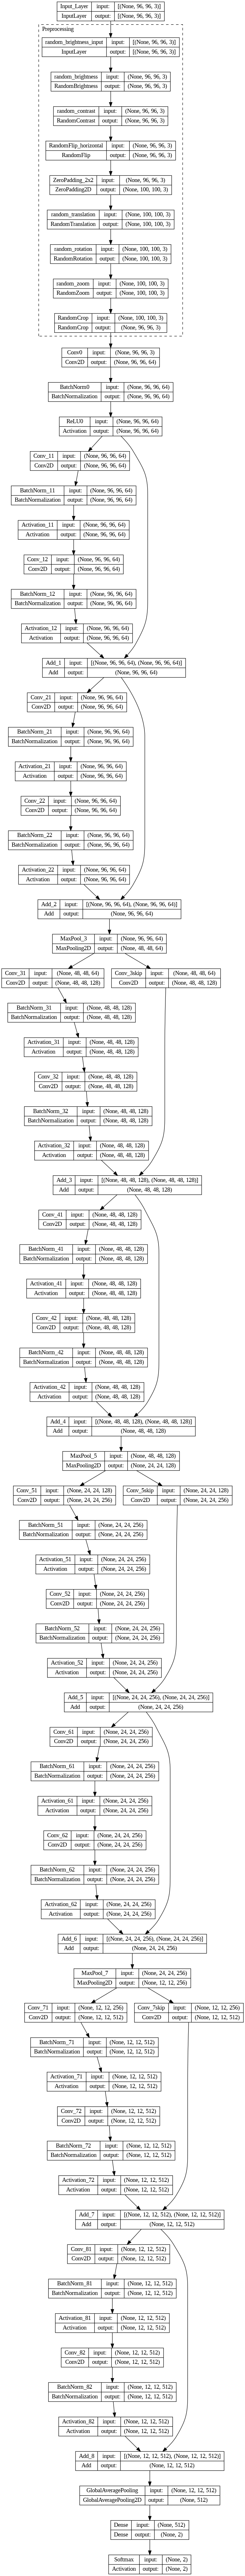

In [11]:
residual_model = build_model_residual()
residual_model.summary()
tfk.utils.plot_model(residual_model, expand_nested=True, show_shapes=True)

### Training the model

In [12]:
residual_history = residual_model.fit(
    data_train,
    labels_train,
    validation_data=(data_val,labels_val),
    epochs=epochs,
    batch_size=batch_size,
    verbose=1,
    callbacks=callbacks
).history

Epoch 1/1000
64/64 [==============================] - 58s 487ms/step - loss: 0.7616 - accuracy: 0.6283 - val_loss: 1.7846 - val_accuracy: 0.6208 - lr: 1.0000e-04
Epoch 2/1000
64/64 [==============================] - 26s 412ms/step - loss: 0.6217 - accuracy: 0.6703 - val_loss: 2.8001 - val_accuracy: 0.6208 - lr: 1.0000e-04
Epoch 3/1000
64/64 [==============================] - 26s 412ms/step - loss: 0.6212 - accuracy: 0.6782 - val_loss: 2.1865 - val_accuracy: 0.6208 - lr: 1.0000e-04
Epoch 4/1000
64/64 [==============================] - 27s 415ms/step - loss: 0.6035 - accuracy: 0.6890 - val_loss: 2.2371 - val_accuracy: 0.6208 - lr: 1.0000e-04
Epoch 5/1000
64/64 [==============================] - 26s 410ms/step - loss: 0.5762 - accuracy: 0.7038 - val_loss: 2.8483 - val_accuracy: 0.6208 - lr: 1.0000e-04
Epoch 6/1000
64/64 [==============================] - 26s 412ms/step - loss: 0.5812 - accuracy: 0.6999 - val_loss: 1.2228 - val_accuracy: 0.6208 - lr: 1.0000e-04
Epoch 7/1000
64/64 [========

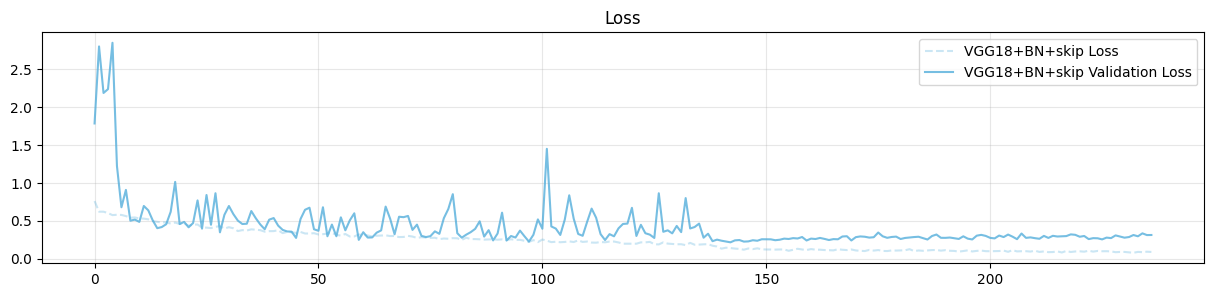

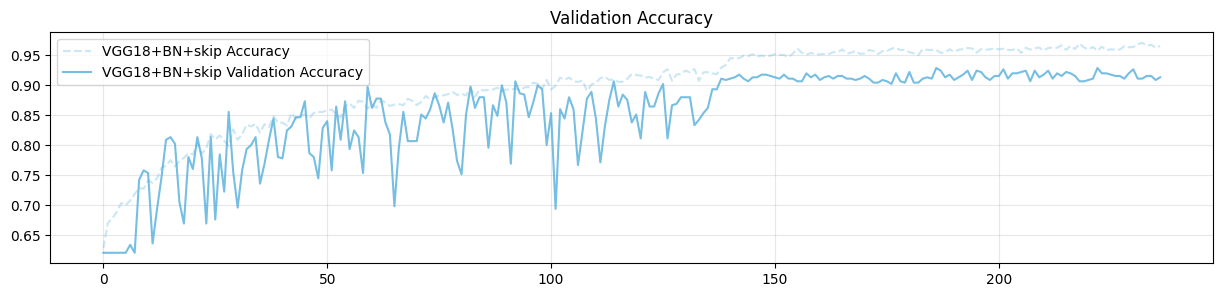

In [13]:
# Plot validation loss
plt.figure(figsize=(15, 3))
plt.plot(residual_history['loss'], label="VGG18+BN+skip Loss", alpha=.3, color='#54aedb', linestyle='--')
plt.plot(residual_history['val_loss'], label='VGG18+BN+skip Validation Loss', alpha=0.8, color='#54aedb')
plt.title('Loss')
plt.legend()
plt.grid(alpha=0.3)

# Plot validation accuracy
plt.figure(figsize=(15, 3))
plt.plot(residual_history['accuracy'], label="VGG18+BN+skip Accuracy", alpha=.3, color='#54aedb', linestyle='--')
plt.plot(residual_history['val_accuracy'], label='VGG18+BN+skip Validation Accuracy', alpha=0.8, color='#54aedb')
plt.title('Validation Accuracy')
plt.legend()
plt.grid(alpha=0.3)

# Show the plots
plt.show()

In [23]:
# Predict labels for the entire test set
predictions = residual_model.predict(data_test, verbose=0)

In [25]:
# Evaluate the model on the test set
test_accuracy = residual_model.evaluate(data_test,labels_test,verbose=0)[-1]
print('Test set accuracy %.4f' % test_accuracy)

Test set accuracy 0.9082


In [26]:
y = np.array(labels_test)

### Confusion matrix

Accuracy: 0.9082
Precision: 0.9056
Recall: 0.8987
F1: 0.9019


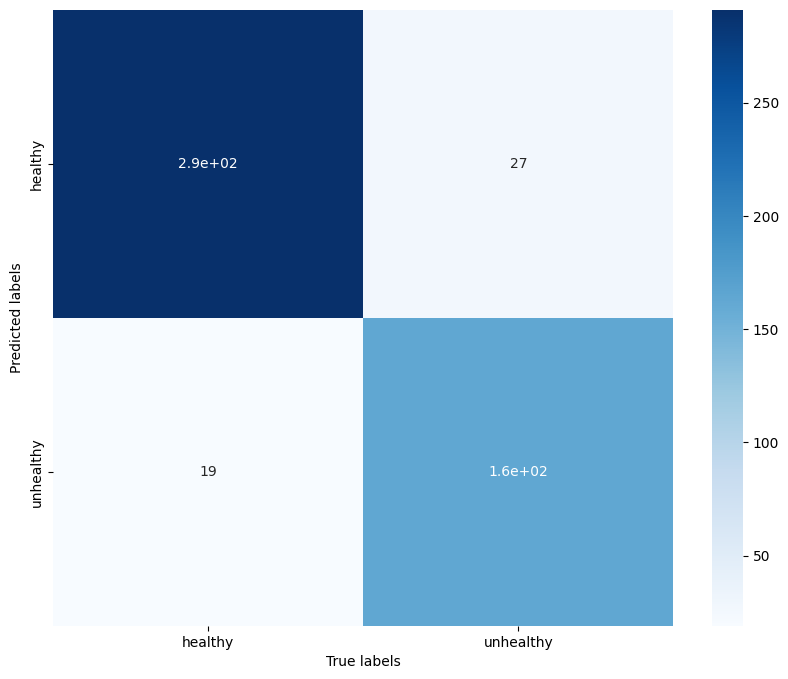

In [27]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y, axis=-1), np.argmax(predictions, axis=-1))

# Compute classification metrics
accuracy = accuracy_score(np.argmax(y, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y, axis=-1), np.argmax(predictions, axis=-1), average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, xticklabels=list(("healthy", "unhealthy")), yticklabels=list(("healthy", "unhealthy")), cmap='Blues', annot=True)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [18]:
residual_model.save('residual_model')
del residual_model